In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

import random
seed_value = 58

torch.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(seed_value)
random.seed(seed_value)

class GNNRegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNRegressionModel, self).__init__()

        # Graph Convolution layer to learn weights
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim*2)
        self.conv3 = GCNConv(hidden_dim*2, hidden_dim*2)

        # Regression to predict next pandemic data
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply Graph Convolution layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))

        # Fully connected layer for regression
        x = self.fc(x)

        return x

In [3]:
# Import Tweet Data
import json
f = open('gb_week.json')
tweet_data = json.load(f)       # dictionary (city name : vector of weekly avgerge tweet count)

# City Information
city_count = len(tweet_data)                    # number of cities
city_names = list(tweet_data.keys())            # city names
city_codes = np.arange(166)                     # assign city codes (start from 0)
city_dict = dict(zip(city_codes, city_names))   # dictionary (city code : city name)

# Data Information
week_count = len(tweet_data[city_dict[0]])      # how many weeks of data is available
feature_count = 3                               # how many weeks of data is considered as feature (input)
set_count = week_count-feature_count            # how many training sets can be extracted
training_set_count = 7                         # how many sets used for training

feature_mean = np.mean(list(tweet_data.values())) # mean weekly avg. tweet count among all cities
feature_std = np.std(list(tweet_data.values())) # standard deviation

# Node Features (City, Set, Feature)
node_features = np.zeros((city_count, set_count, feature_count))
for city in range(city_count):
    city_name = city_dict[city]
    for set in range(set_count):
        start = set
        end = set + feature_count
        node_features[city,set,:] = tweet_data[city_name][start:end]
node_features = (node_features-feature_mean)/feature_mean # normalization

# Target Values (City, Set, Target)
target_values = np.zeros((city_count, set_count, 1))
for city in range(city_count):
    city_name = city_dict[city]
    for set in range(set_count):
        target = set + feature_count
        target_values[city,set,0] = tweet_data[city_name][target]
target_values = (target_values-feature_mean)/feature_mean # normalization

# Edge Index
A = np.ones((city_count,city_count)) # adjacency matrix
G = nx.from_numpy_array(A)
edges = np.array(G.edges)
edges_rev = edges[:,[1,0]]
edge_index = np.vstack((edges,edges_rev)).T

In [4]:
# Initializing Model
input_dim = feature_count
hidden_dim = input_dim
output_dim = 1

model = GNNRegressionModel(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
model.train()
num_epochs = 50
loss_each_epoch = []

for epoch in range(num_epochs):
    for set in range(training_set_count):
        x_train = torch.tensor(node_features[:,set,:],dtype=torch.float)
        edge_train = torch.tensor(edge_index,dtype=int)
        y_train = torch.tensor(target_values[:,set,:],dtype=torch.float)
        train_data = Data(x=x_train, edge_index=edge_train, y=y_train)

        optimizer.zero_grad()
        output = model(train_data)
        loss = criterion(output, train_data.y)
        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')
    
    loss_each_epoch.append(loss.item())

Epoch 1/50, Loss: 2.966059923171997
Epoch 1/50, Loss: 5.374599456787109
Epoch 1/50, Loss: 6.534616470336914
Epoch 1/50, Loss: 5.3301472663879395
Epoch 1/50, Loss: 7.574316501617432
Epoch 1/50, Loss: 15.213481903076172
Epoch 1/50, Loss: 17.23565673828125
Epoch 2/50, Loss: 2.9508328437805176
Epoch 2/50, Loss: 5.37372350692749
Epoch 2/50, Loss: 6.530310153961182
Epoch 2/50, Loss: 5.332496166229248
Epoch 2/50, Loss: 7.562924385070801
Epoch 2/50, Loss: 15.175601959228516
Epoch 2/50, Loss: 17.119029998779297
Epoch 3/50, Loss: 2.9831995964050293
Epoch 3/50, Loss: 5.388066291809082
Epoch 3/50, Loss: 6.530020236968994
Epoch 3/50, Loss: 5.337035179138184
Epoch 3/50, Loss: 7.549065113067627
Epoch 3/50, Loss: 15.142868995666504
Epoch 3/50, Loss: 17.0369873046875
Epoch 4/50, Loss: 3.0112838745117188
Epoch 4/50, Loss: 5.399444580078125
Epoch 4/50, Loss: 6.530710220336914
Epoch 4/50, Loss: 5.340707302093506
Epoch 4/50, Loss: 7.540238857269287
Epoch 4/50, Loss: 15.120427131652832
Epoch 4/50, Loss: 16.

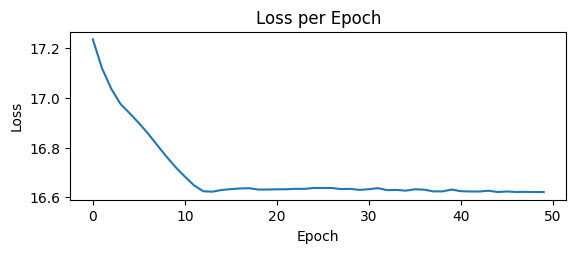

In [5]:
# Training Visualization 
plt.subplot(2,1,1)
plt.plot(range(len(loss_each_epoch)),loss_each_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.show()

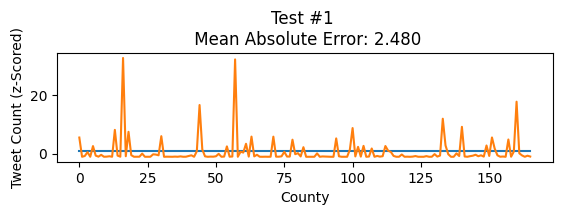

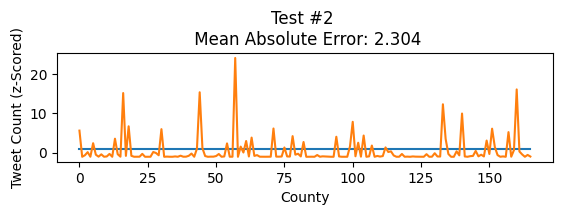

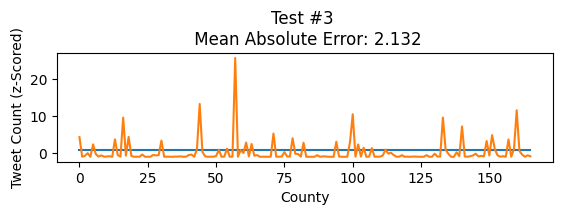

In [8]:
# Testing
test_sets = np.arange(training_set_count, set_count, 1)

for set in test_sets:
    x_test = torch.tensor(node_features[:,set,:],dtype=torch.float)
    edge_test = torch.tensor(edge_index,dtype=int)
    y_test = torch.tensor(target_values[:,set,:],dtype=torch.float)
    test_data = Data(x=x_test, edge_index=edge_test, y=y_test)

    model.eval()
    predictions = model(test_data).detach().numpy()
    target = test_data.y.numpy()
    mae = np.mean(np.abs(predictions - target))

    # Test Visualization
    test_num = set - training_set_count + 1
    plt.subplot(3,1,test_num)
    plt.plot(range(len(predictions)), predictions)
    plt.plot(range(len(y_test)), y_test)
    plt.xlabel("County")
    plt.ylabel("Tweet Count (z-Scored)")
    plt.title(f'Test #{test_num} \n Mean Absolute Error: {mae:.3f}')
    plt.show()